In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

In [5]:
df = pd.read_csv('PJME_hourly.csv')
df = df.set_index('Datetime')
df.index = pd.to_datetime(df.index)

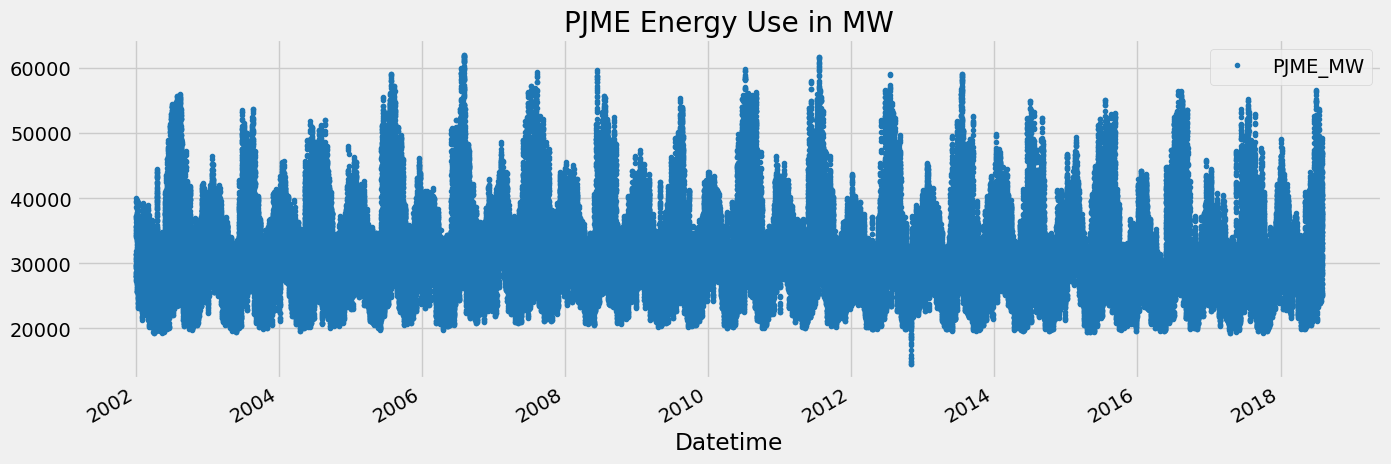

In [6]:
df.plot(style='.',
        figsize=(15, 5),
        color=color_pal[0],
        title='PJME Energy Use in MW')
plt.show()

In [7]:
# Train Test Split

train = df.loc[df.index < '01-01-2015']
test = df.loc[df.index >= '01-01-2015']

train = df.loc[df.index < '01-01-2015']
test = df.loc[df.index >= '01-01-2015']

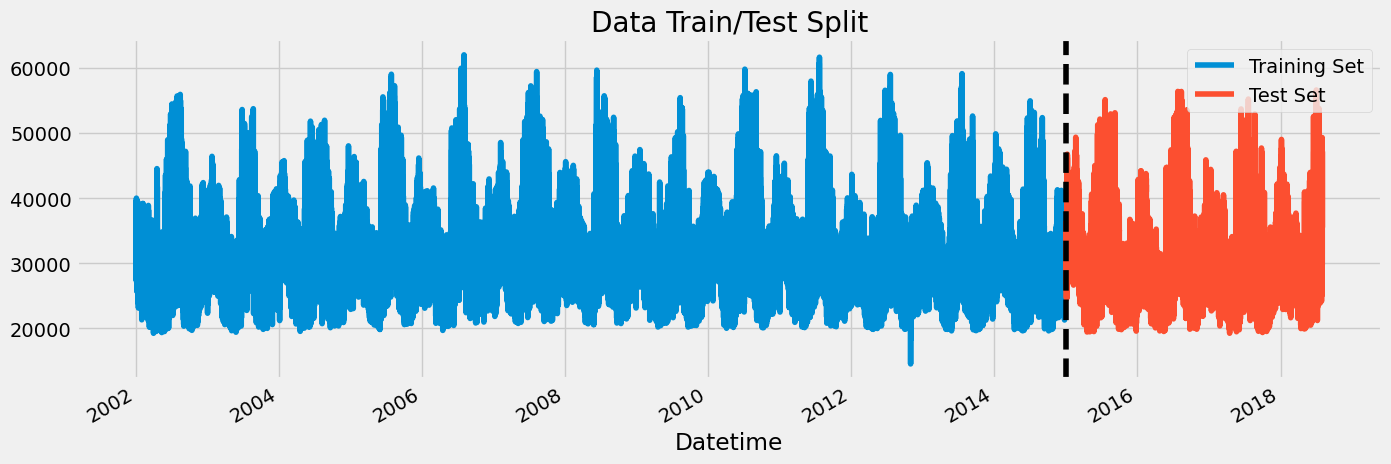

In [8]:
fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test.plot(ax=ax, label='Test Set')
ax.axvline('01-01-2015', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

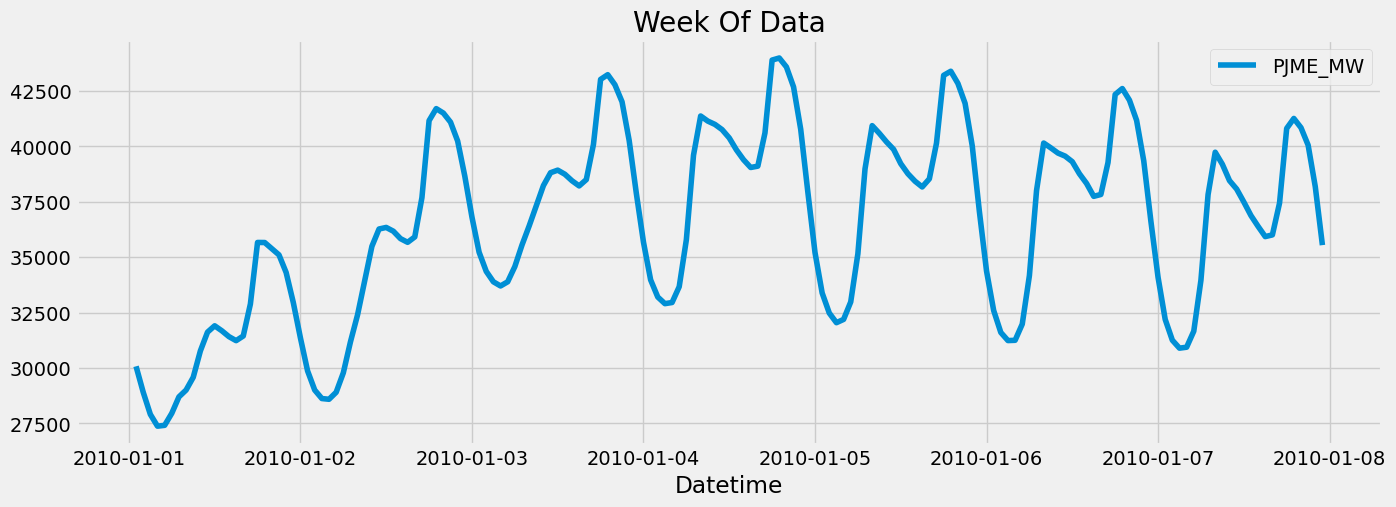

In [9]:
fig, ax  = plt.subplots(figsize=(15,5))
sns.lineplot(data=df.loc[(df.index > '2010-01-01') & (df.index < '2010-01-08')])
plt.title('Week Of Data')
plt.show()

In [10]:
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

In [11]:
df = create_features(df)

Text(0.5, 1.0, 'MW By Hour')

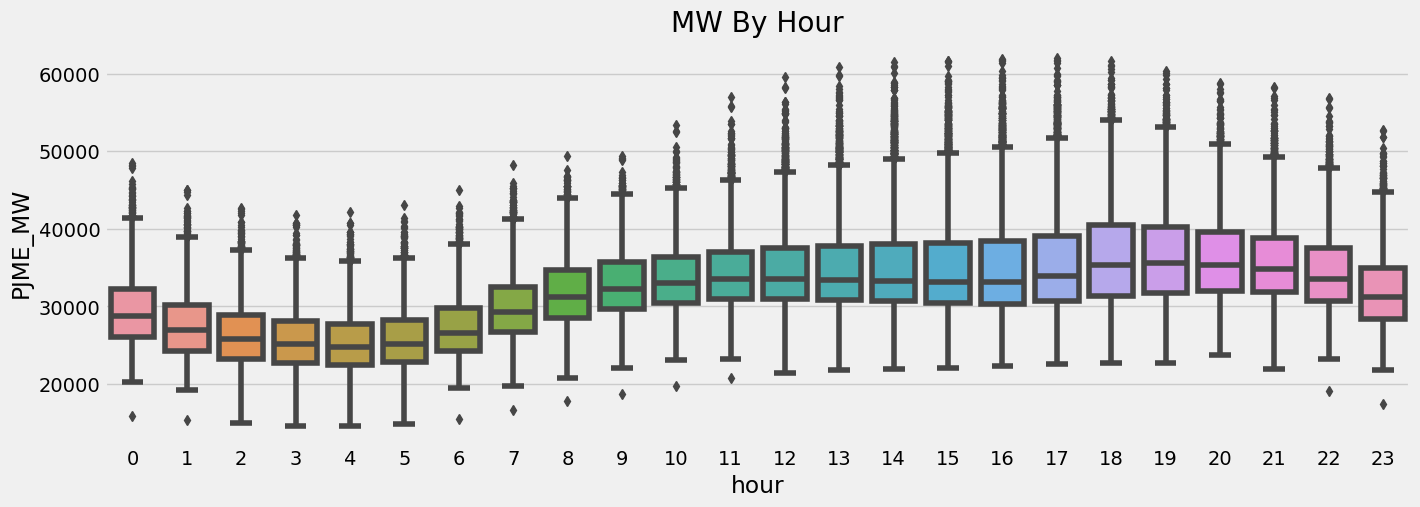

In [12]:
fig, ax  = plt.subplots(figsize=(15,5))
sns.boxplot(df,x='hour',y='PJME_MW')
ax.set_title('MW By Hour')

Text(0.5, 1.0, 'MW By Hour')

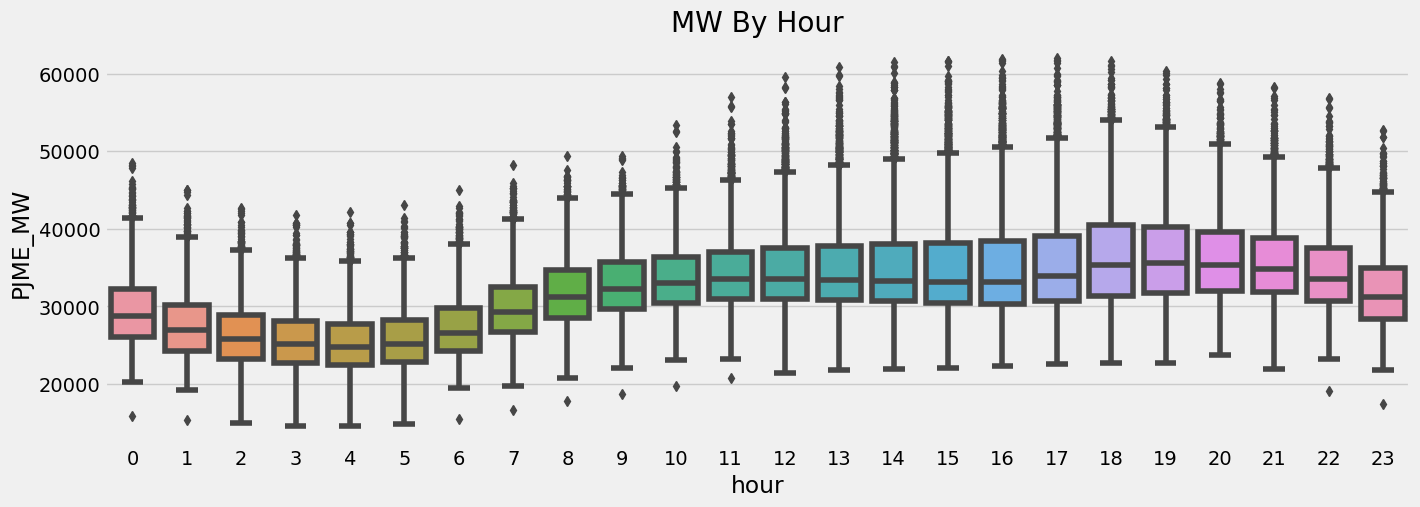

In [13]:
fig, ax  = plt.subplots(figsize=(15,5))
sns.boxplot(df,x='hour',y='PJME_MW')
ax.set_title('MW By Hour')

In [14]:
train = create_features(train)
test = create_features(test)

FEATURES = [
 'hour',
 'dayofweek',
 'month',
 'quarter',
 'dayofyear',
 'year',
 'dayofmonth',
 'weekofyear']
TARGET= 'PJME_MW'

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

In [15]:
reg = xgb.XGBRegressor(n_estimators = 1000,early_stopping_rounds=50,learning_rate = 0.01)
reg.fit(X_train,y_train,eval_set=[(X_train,y_train),(X_test,y_test)])

[0]	validation_0-rmse:6407.32558	validation_1-rmse:6479.90312
[1]	validation_0-rmse:6362.95260	validation_1-rmse:6438.65470
[2]	validation_0-rmse:6319.24273	validation_1-rmse:6398.29218
[3]	validation_0-rmse:6275.99217	validation_1-rmse:6358.73108
[4]	validation_0-rmse:6233.32679	validation_1-rmse:6319.84676
[5]	validation_0-rmse:6191.25747	validation_1-rmse:6281.82277
[6]	validation_0-rmse:6149.72597	validation_1-rmse:6244.15172
[7]	validation_0-rmse:6108.77159	validation_1-rmse:6207.14046
[8]	validation_0-rmse:6068.28916	validation_1-rmse:6169.82050
[9]	validation_0-rmse:6028.36020	validation_1-rmse:6133.84120
[10]	validation_0-rmse:5988.99958	validation_1-rmse:6098.29696
[11]	validation_0-rmse:5950.11101	validation_1-rmse:6063.27689
[12]	validation_0-rmse:5911.36581	validation_1-rmse:6028.44272
[13]	validation_0-rmse:5873.53185	validation_1-rmse:5994.69038
[14]	validation_0-rmse:5835.83304	validation_1-rmse:5960.88178
[15]	validation_0-rmse:5798.50197	validation_1-rmse:5927.88947
[1

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

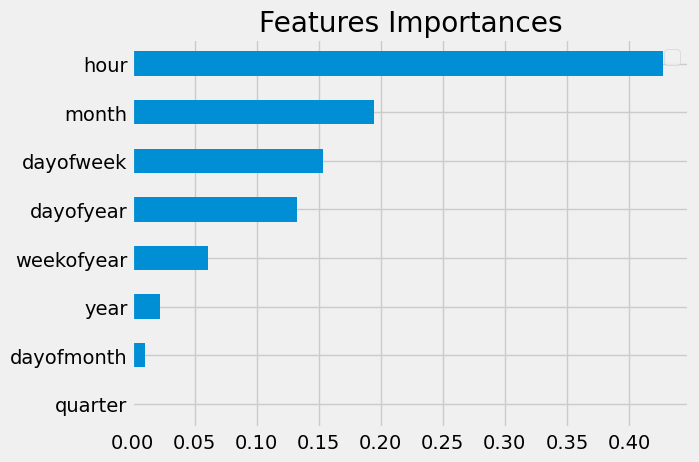

In [16]:
feature_importances  = pd.DataFrame(data=reg.feature_importances_,index = reg.feature_names_in_,columns=['importances'])
feature_importances = feature_importances.sort_values(by = 'importances',ascending=1)
feature_importances.plot(kind='barh')
plt.legend('')
plt.title('Features Importances')

test['prediciton'] = reg.predict(X_test)

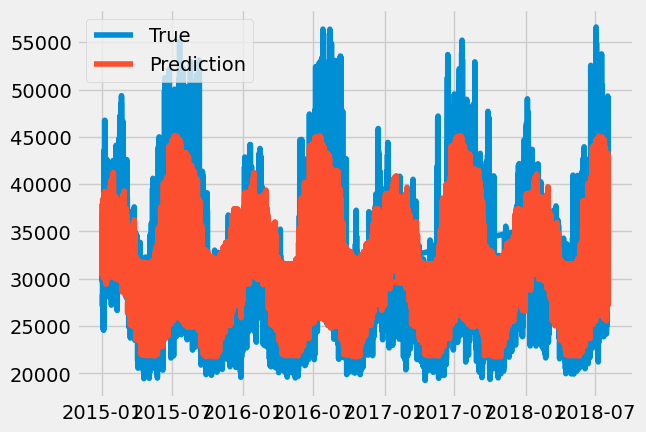

In [17]:
plt.plot(test['PJME_MW'],label='True')
plt.plot(test['prediciton'],label='Prediction')

plt.legend()

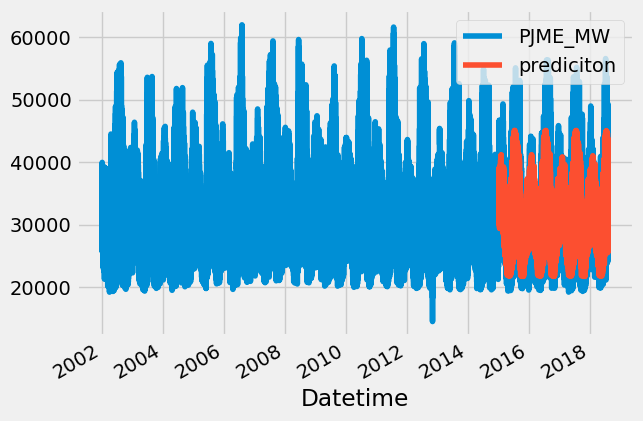

In [18]:
df['PJME_MW'].plot()
test['prediciton'].plot()
plt.legend()

In [19]:
# Filtering data
filtered_data = test.loc[(test.index > '04-01-2018') & (test.index < '04-08-2018')]

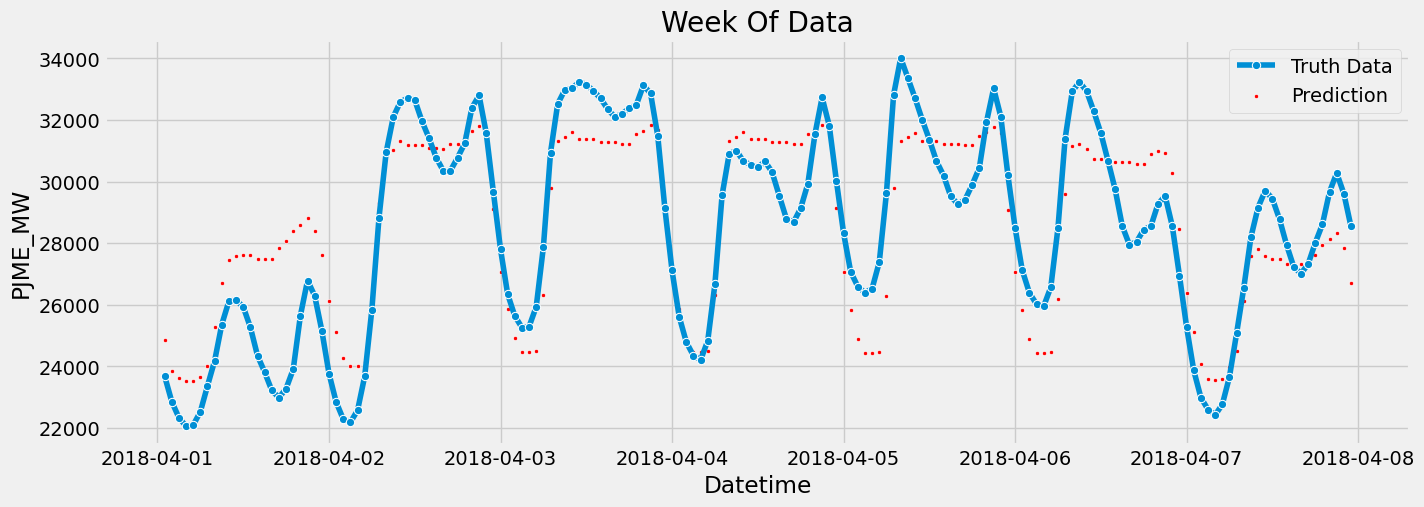

In [20]:
# Plotting
plt.figure(figsize=(15, 5))
sns.lineplot(data=filtered_data['PJME_MW'], marker='o', label='Truth Data')
sns.scatterplot(data=filtered_data['prediciton'], marker='.', label='Prediction',color='red')
plt.title('Week Of Data')
plt.legend()
plt.show()

In [21]:
mean_squared_error(test['PJME_MW'],test['prediciton'])

test['error'] = test['PJME_MW'] - test['prediciton']
test['abs_error'] = test['error'].apply(np.abs)
error_by_day = test.groupby(['year','month','dayofmonth']) \
    .mean()[['PJME_MW','prediciton','error','abs_error']]

In [22]:
# Over forecasted days
error_by_day.sort_values('error', ascending=True).head(10)

PJME_MW    prediciton        error    abs_error
year month dayofmonth                                                      
2016 7     4           28399.958333  37709.214844 -9309.255534  9309.255534
2017 2     24          26445.083333  34589.839844 -8144.756917  8144.756917
     9     1           27280.500000  35337.847656 -8057.346110  8057.346110
     5     29          24528.416667  32501.271484 -7972.854492  7972.854492
     9     2           24201.458333  32115.951172 -7914.491130  7914.491130
     2     25          24344.458333  32157.929688 -7813.472493  7813.472493
     9     4           26552.416667  34002.074219 -7449.655273  7449.655273
     2     20          27070.583333  34388.093750 -7317.511068  7317.511068
           28          28297.875000  35543.996094 -7246.121257  7246.121257
     6     8           26943.791667  34187.574219 -7243.782796  7243.782796

In [23]:
# Worst absolute predicted days
error_by_day.sort_values('abs_error', ascending=False).head(10)


PJME_MW    prediciton         error     abs_error
year month dayofmonth                                                        
2016 8     13          45185.833333  31513.306641  13672.526449  13672.526449
           14          44427.333333  30970.671875  13456.660807  13456.660807
     9     10          40996.166667  29922.265625  11073.900309  11073.900309
     8     12          45724.708333  35059.285156  10665.421712  10665.421712
2018 1     6           43565.750000  32917.519531  10648.232340  10648.232340
2016 9     9           43836.958333  33312.636719  10524.319824  10524.319824
2015 2     20          44694.041667  34169.910156  10524.132731  10524.132731
2018 1     7           42159.708333  32764.650391   9395.057861   9395.057861
2017 5     19          38032.583333  28645.845703   9386.738118   9386.738118
2015 2     16          43949.500000  34571.339844   9378.161540   9378.161540

In [24]:
# Best predicted days
error_by_day.sort_values('abs_error', ascending=True).head(10)

PJME_MW    prediciton       error   abs_error
year month dayofmonth                                                    
2016 12    30          32213.458333  32329.289062 -115.829915  362.415690
2017 10    24          28657.416667  28814.763672 -157.345133  406.268148
2016 4     4           28944.125000  29177.695312 -233.569417  440.718831
     10    27          28611.166667  28802.400391 -191.234863  441.637044
2015 10    28          28500.958333  28817.468750 -316.509521  442.257080
2017 5     2           28546.916667  28869.001953 -322.087077  458.298828
2016 6     3           31502.625000  31374.287109  128.338460  494.025146
2017 4     1           27047.041667  27098.564453  -51.522542  533.044678
2016 8     8           36256.041667  36199.925781   56.117269  577.245361
2018 4     19          28949.958333  28921.603516   28.354411  582.060791